In [1]:
from kafka import KafkaConsumer
import pandas as pd
import pickle
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

### Load pickled pipline XGBoost models from pickel file


In [2]:
with open(r'xgp_mutual.pkl', 'rb') as file:
    static_model = pickle.load(file)
with open(r'D:/ass3Cv/xgp_mutual.pkl', 'rb') as file:
    dynamic_model  = pickle.load(file)

In [3]:
static_model_performance = []
dynamic_model_performance = []

### Function to clear 1000 rows of messages


In [4]:
def clear_1000_row(c):
    messages = []
    for message in c:
        decoded_message = message.value.decode("utf-8").strip("\n").strip('"')
        message_values = decoded_message.split(",")
        message_values[-1] = int(message_values[-1].strip(r"\n"))

        messages.append(message_values)
        if len(messages) >= 1000:
                break

    return messages

### The top features from mutual_info in static model job 

In [5]:
top_features =['sld', 'longest_word', 'labels', 'special', 'entropy', 'FQDN_count']

### Evaluate and retrain models based on performance


In [6]:

from sklearn.preprocessing import MinMaxScaler
def evaluate_and_retrain_model(df, dynamic_model,static_model):
    X = df.drop("Target Attack", axis=1)
    y = df["Target Attack"]
    X = X[top_features]
    
    df = pd.concat([X, y], axis=1)
    df.to_csv('merged_data.csv', index=False)
    static_prediction = static_model.predict(X)
    dynamic_prediction = dynamic_model.predict(X)

    static_accuracy = f1_score(y, static_prediction,average='weighted')
    dynamic_accuracy = f1_score(y, dynamic_prediction,average='weighted')
    static_model_performance.append(static_accuracy)
    print(f"static_accuracy: {static_accuracy}")
    print(f"before {dynamic_accuracy}")
    if dynamic_accuracy < .79:  
        dynamic_model.fit(X, y) 
        dynamic_prediction = dynamic_model.predict(X)
        dynamic_accuracy = f1_score(y, dynamic_prediction,average='weighted')
        print(f"after: {dynamic_accuracy}")

    dynamic_model_performance.append(dynamic_accuracy)    

    return dynamic_model

### Kafka Consumer initialization


In [7]:
consumer = KafkaConsumer(
    'ml-raw-dns',
    bootstrap_servers="localhost:9092",
    auto_offset_reset='earliest',
    enable_auto_commit=False
)

### Clear First Row because I will use the header manualy  

In [8]:
for message in consumer:
    break

In [10]:
column_names = ["timestamp", "FQDN_count", "subdomain_length", "upper", "lower", "numeric", 
                    "entropy", "special", "labels", "labels_max", "labels_average",
                    "longest_word", "sld", "len", "subdomain", "Target Attack"]

### Preprocessing function to drop timestamp, apply hash to 'longest_word' and 'sld' columns


In [9]:
def  preprocessing (df):
    df.drop("timestamp",axis=1,inplace=True)
    df['longest_word'] = df['longest_word'].apply(hash)
    df['sld'] = df['sld'].apply(hash)
    return df

### Function to consume messages, create DataFrame that contain 1000 row, and apply preprocessing


In [11]:
def consume_messages():
    df = pd.DataFrame(clear_1000_row(consumer), columns=column_names)
    df = preprocessing(df)
    return df

### Execute a loop 260 times to assess the model on 260,000 records from the Kafka dataset. Each iteration should handle a data frame containing 1,000 rows


In [12]:
for i in range (260):
    df = consume_messages()
    dynamic_model = evaluate_and_retrain_model(df, dynamic_model,static_model)

static_accuracy: 0.8047530736133978
before 0.8047530736133978
static_accuracy: 0.7985770913770914
before 0.7985770913770914
static_accuracy: 0.7766792212622768
before 0.7766792212622768
after: 0.7872631444252021
static_accuracy: 0.8031104795597228
before 0.8016011926362557


c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


static_accuracy: 0.7865458849677649
before 0.7892158288008947
after: 0.8021655474089512
static_accuracy: 0.7926669747666143
before 0.7908189258600428
static_accuracy: 0.7870887012352571
before 0.7957274679700809
static_accuracy: 0.7897967303358694
before 0.7943290752265532
static_accuracy: 0.7978747173224785
before 0.7962190318158863
static_accuracy: 0.8095476460578559
before 0.8132210905646252
static_accuracy: 0.7972032533582053
before 0.8042669472143446
static_accuracy: 0.805491004158306
before 0.8087405959941377
static_accuracy: 0.796695577494547
before 0.7947934466832726
static_accuracy: 0.7908003528355076
before 0.7871292104119046
after: 0.7951522381620106
static_accuracy: 0.8049790680095521
before 0.8093528580671571


c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


static_accuracy: 0.8055886409736308
before 0.8055692373372366
static_accuracy: 0.7833155727155726
before 0.7864695933556249
after: 0.7913242638965328
static_accuracy: 0.7751618940066146
before 0.7742186640066043
after: 0.7827242020549536
static_accuracy: 0.8219358487770848
before 0.8236703527927532


c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


static_accuracy: 0.8077948717948717
before 0.8061339283160274
static_accuracy: 0.7892543855436345
before 0.7957215787215787
static_accuracy: 0.8099945867593674
before 0.8133118464501926
static_accuracy: 0.7862971627220094
before 0.7919871963058193
static_accuracy: 0.7960848019904624
before 0.7954791463462213
static_accuracy: 0.8011274743492285
before 0.8030418390804599
static_accuracy: 0.8003278587420539
before 0.8051224295520876
static_accuracy: 0.7956263888888888
before 0.7955258789558612
static_accuracy: 0.8053468624765543
before 0.8019714919227114
static_accuracy: 0.8022478193337829
before 0.807534730127018
static_accuracy: 0.7924453846696283
before 0.7952904584151715
static_accuracy: 0.7822168934998263
before 0.7869597597597597


c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


after: 0.7904313523942905
static_accuracy: 0.7751081029406142
before 0.7754087456383215
after: 0.782768321279825
static_accuracy: 0.8197228907528988
before 0.8177962913784455
static_accuracy: 0.797660685541944
before 0.7978356318580176
static_accuracy: 0.8009813333333333
before 0.7990703764320786
static_accuracy: 0.7898353462851103
before 0.7914150943396225
static_accuracy: 0.822886949795645
before 0.8164181847419081
static_accuracy: 0.797739580468112
before 0.8011232391650882
static_accuracy: 0.79374718896996
before 0.785728420995347
after: 0.8008375924857007
static_accuracy: 0.8036564618861722
before 0.8082617854368839
static_accuracy: 0.7895829004179834
before 0.7891377980260826


c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


after: 0.7990823934612873
static_accuracy: 0.7952383283570194
before 0.797167650694621
static_accuracy: 0.8057410097566561
before 0.8052172204358699
static_accuracy: 0.7927487819138571
before 0.7947777561026362
static_accuracy: 0.7895431612412744
before 0.7936619846919973
static_accuracy: 0.7984105668684645
before 0.7960561611921093
static_accuracy: 0.784298021978022
before 0.7961435957981614
static_accuracy: 0.8178248109376186
before 0.8269690352263875
static_accuracy: 0.7932593220466442
before 0.7966698979773551
static_accuracy: 0.7964034067100215
before 0.8019117498093861
static_accuracy: 0.7931488529270045
before 0.7939053489487021
static_accuracy: 0.7911156410744904
before 0.7947074513621213
static_accuracy: 0.8057481218395176
before 0.800773435906402
static_accuracy: 0.7944541471701486
before 0.7948271938512229
static_accuracy: 0.7801243422334827
before 0.7868184400447436


c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


after: 0.7959403533740365
static_accuracy: 0.7948883606658972
before 0.7923640079744015
static_accuracy: 0.7816037735020785
before 0.7804256341155655
after: 0.7920099743620642
static_accuracy: 0.8318852247140066
before 0.8391279583229968
static_accuracy: 0.8170809132996633
before 0.8230276923076922
static_accuracy: 0.8018790104030072
before 0.8013036454085528
static_accuracy: 0.7835541827454815
before 0.7833610521607552
after: 0.7932626052759686


c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


static_accuracy: 0.7948292328789223
before 0.7984417635574205
static_accuracy: 0.8066008512269605
before 0.8061578317108332
static_accuracy: 0.7885081597313324
before 0.7894985805395272
after: 0.7980036883965158
static_accuracy: 0.7864611440007118
before 0.7860449512317489
after: 0.7940679931647198
static_accuracy: 0.8112799643664389
before 0.8117250275178867


c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


static_accuracy: 0.7993401294112467
before 0.8033530908015379
static_accuracy: 0.7943214673391464
before 0.7983361812040533
static_accuracy: 0.7905840814870321
before 0.7899505210742565
after: 0.7996720038593187


c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


static_accuracy: 0.8111931830439004
before 0.8159932386747801
static_accuracy: 0.8107217457866809
before 0.8082395883457097
static_accuracy: 0.7981643163984945
before 0.7970837279823297
static_accuracy: 0.7952876971061651
before 0.7969997692833511
static_accuracy: 0.7960544526375497
before 0.7986778549678659
static_accuracy: 0.7862357139258607
before 0.7858155261266545
after: 0.7913992277992278
static_accuracy: 0.7898093503966666
before 0.7862157014157014


c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


after: 0.799328356916469
static_accuracy: 0.7751122080163997
before 0.7764431378393146
after: 0.7835656153143703
static_accuracy: 0.7957672464648993
before 0.7969554584524644
static_accuracy: 0.8141652669724982
before 0.817437430654751


c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


static_accuracy: 0.7973614086398056
before 0.8050003221109866
static_accuracy: 0.8077212736022252
before 0.8081048051654223
static_accuracy: 0.80765862062934
before 0.8101640030706958
static_accuracy: 0.7887247825847293
before 0.7919541734860884
static_accuracy: 0.8059131086338114
before 0.8055132656403536
static_accuracy: 0.7935133406356436
before 0.7961766456650303
static_accuracy: 0.7903441981747067
before 0.7894327047411416


c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


after: 0.7953571855293727
static_accuracy: 0.7797435407186467
before 0.7792101255847469
after: 0.7871288377099316
static_accuracy: 0.8032208693560785
before 0.8047626829394425
static_accuracy: 0.8179047921462783
before 0.8155074150553783
static_accuracy: 0.8063966525010412
before 0.806217388647889
static_accuracy: 0.7889858731863612
before 0.7972135632445165
static_accuracy: 0.8002637670368624
before 0.8036504182716884
static_accuracy: 0.7947650325180377
before 0.7968700065434938
static_accuracy: 0.8045129704055535
before 0.8059376557026696
static_accuracy: 0.8245429300010226
before 0.8253259995768986
static_accuracy: 0.7955261067681118
before 0.7999057075382254
static_accuracy: 0.79069192716378
before 0.7912646331077476
static_accuracy: 0.7958696129922
before 0.7996905343227213
static_accuracy: 0.8068527847149978
before 0.8097222222222221
static_accuracy: 0.7772438625204582
before 0.7763843572358058
after: 0.7871403979116692
static_accuracy: 0.8133208238302577
before 0.814280540395106

c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


static_accuracy: 0.8209915110356537
before 0.8208374440747964
static_accuracy: 0.7949433344251556
before 0.7942934553872053
static_accuracy: 0.7975936436234572
before 0.7932018744259517
static_accuracy: 0.8093669170169723
before 0.8038034685102657
static_accuracy: 0.8088776726065362
before 0.806969696969697
static_accuracy: 0.8093353745132956
before 0.8054959606259688
static_accuracy: 0.7904197377629303
before 0.7883027654171013


c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Pa

after: 0.7985084066498294
static_accuracy: 0.7659521693335906
before 0.7711757507435125
after: 0.7812392880685564
static_accuracy: 0.808910016510732
before 0.8075315389356894
static_accuracy: 0.7866079203815053
before 0.7836602316602317
after: 0.7913565139596067
static_accuracy: 0.8054189117802429
before 0.81020580783473
static_accuracy: 0.8214004012247914
before 0.8239979572614166
static_accuracy: 0.7885852519479459
before 0.7879627699036622
after: 0.7987112365894975
static_accuracy: 0.8073876945565258
before 0.803392758647304
static_accuracy: 0.7929253559453864
before 0.7925222356578097
static_accuracy: 0.7972058074315548
before 0.7943497983306861
static_accuracy: 0.7928276207523959
before 0.7953371766444937


c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


static_accuracy: 0.8065108225108224
before 0.8105180276749172
static_accuracy: 0.7949097552171959
before 0.796991889681996
static_accuracy: 0.796015918182193
before 0.7916447725648964
static_accuracy: 0.8047430751067115
before 0.8049307484967863
static_accuracy: 0.8122759699927402
before 0.8135876979372012
static_accuracy: 0.7932670341448477
before 0.8025762068140109
static_accuracy: 0.7985459340410253
before 0.8006554007002815
static_accuracy: 0.8082880426166091
before 0.8080607578397213
static_accuracy: 0.7937142157938263
before 0.7931771352158807
static_accuracy: 0.8295737451737453
before 0.827314340676756
static_accuracy: 0.820582297192007
before 0.8194718063830146
static_accuracy: 0.7847186631176712
before 0.787183394750504
after: 0.7951906167717226
static_accuracy: 0.7861785610330502
before 0.7949326115315212
static_accuracy: 0.7977304374763512
before 0.803076474792457
static_accuracy: 0.8172568916183962
before 0.8197726772365069
static_accuracy: 0.7991401810747407
before 0.80325

c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


static_accuracy: 0.8307653592104939
before 0.837390962976355
static_accuracy: 0.7974107744107743
before 0.8024808294002228
static_accuracy: 0.7869182224060953
before 0.781587079881567
after: 0.7886032206786924
static_accuracy: 0.8267977000432729
before 0.8266215165798395
static_accuracy: 0.794513496314366
before 0.7912227183729694
static_accuracy: 0.8023724578957524
before 0.8044861214476694
static_accuracy: 0.8026168213109848
before 0.8037724116326423


c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


static_accuracy: 0.7932090536517198
before 0.7951054281124658
static_accuracy: 0.7860063493729339
before 0.7841150343924009
after: 0.7935925274725275
static_accuracy: 0.7777551326105124
before 0.7800903566337586


c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


after: 0.7881560173257283
static_accuracy: 0.7848508848828982
before 0.7912198582195592
static_accuracy: 0.803672877846791
before 0.8009945508057232
static_accuracy: 0.8147915902510593
before 0.8169082577910474
static_accuracy: 0.8088833135584078
before 0.8065958946713665
static_accuracy: 0.7709131167000202
before 0.7754047269500686
after: 0.7874186684280223


c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


static_accuracy: 0.789872408124304
before 0.7957889960294952
static_accuracy: 0.7974424894272438
before 0.8026168213109848
static_accuracy: 0.8144630158203341
before 0.813310332687907
static_accuracy: 0.7932593220466442
before 0.7945628502880012
static_accuracy: 0.8221213291511685
before 0.8265105432895063
static_accuracy: 0.8038361365063856
before 0.8020633752293327
static_accuracy: 0.7757351937011882
before 0.7778609264623142
after: 0.7866017911289755
static_accuracy: 0.767168468049163
before 0.7661973709277956


c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


after: 0.7737562677484786
static_accuracy: 0.8224809267038886
before 0.8236453598378616
static_accuracy: 0.7946158215010142
before 0.7986279997963761
static_accuracy: 0.7966694495767112
before 0.8064001148010941
static_accuracy: 0.8256874861880538
before 0.8280942955362214
static_accuracy: 0.7944653688094311
before 0.8007511133102425
static_accuracy: 0.802290244909191
before 0.7982779173592053
static_accuracy: 0.7885496624305847
before 0.7908182826235672
static_accuracy: 0.8059821463293912
before 0.8115020530048526
static_accuracy: 0.8092252134365276
before 0.8077568
static_accuracy: 0.8070982715274441
before 0.8090116914844748
static_accuracy: 0.8093221202348466
before 0.8111688197259689
static_accuracy: 0.8086025974025974
before 0.814955991617451
static_accuracy: 0.8180165153261714
before 0.8197744879509016
static_accuracy: 0.8148866509912371
before 0.821065340909091
static_accuracy: 0.7898337886323817
before 0.7931599859774308
static_accuracy: 0.7857728
before 0.7882145144659625
aft

c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


static_accuracy: 0.8098615735404275
before 0.820010812535451
static_accuracy: 0.80411961337262
before 0.8032608143140344
static_accuracy: 0.8084796020409142
before 0.8079478648833163
static_accuracy: 0.8270561077795121
before 0.8274982372281569
static_accuracy: 0.7961523164690273
before 0.7965515538316779
static_accuracy: 0.8002365818597482
before 0.8025008081412751
static_accuracy: 0.7869120041504138
before 0.7866079203815053
after: 0.7998837764892752
static_accuracy: 0.7956420518757408
before 0.7998774497643265
static_accuracy: 0.7870896628142193
before 0.7861404860502276
after: 0.7930601887751009
static_accuracy: 0.8099924933823239
before 0.8038623737373737
static_accuracy: 0.8145938143928875
before 0.8119408112516378
static_accuracy: 0.8064878015066694
before 0.8013110253110254
static_accuracy: 0.8080859439641103
before 0.8084525760649086
static_accuracy: 0.8293525333333334
before 0.8241368881207747
static_accuracy: 0.7991438132212293
before 0.7947296475807113


c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


static_accuracy: 0.8227978442691047
before 0.8210325074407637
static_accuracy: 0.8180400749733217
before 0.8092407904793099
static_accuracy: 0.8302987732459289
before 0.82436277691654
static_accuracy: 0.797263596031298
before 0.794027305542929
static_accuracy: 0.800343716433942
before 0.7998716746190341
static_accuracy: 0.7893353399846905
before 0.785955912548265
after: 0.7976837528230525
static_accuracy: 0.8095172413793105
before 0.8074240242516104


c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


static_accuracy: 0.8293493784041847
before 0.8355702059465356
static_accuracy: 0.8015336146010977
before 0.8051894736842105
static_accuracy: 0.7982973164179898
before 0.8023349088743095
static_accuracy: 0.7926128631648914
before 0.7881862625813293
after: 0.7977970050899688
static_accuracy: 0.8177475464773
before 0.8153271488842574
static_accuracy: 0.7955208318794055
before 0.7938280164987209
static_accuracy: 0.7758374454549162
before 0.7773451810547756


c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


after: 0.7868497553982168
static_accuracy: 0.8124663102943255
before 0.8153450359164645
static_accuracy: 0.7932593220466442
before 0.797623056189094
static_accuracy: 0.8032057183361345
before 0.8066998310493712
static_accuracy: 0.7971234072204588
before 0.7998056722588395
static_accuracy: 0.801367921475569
before 0.8126522041803721
static_accuracy: 0.7861898039215687
before 0.7930430555555557
static_accuracy: 0.8180996147495873
before 0.8216110304789549
static_accuracy: 0.782187165621308
before 0.7850328770989136
after: 0.7908045275101572
static_accuracy: 0.7868940025000666
before 0.7859438575001276
after: 0.7928024038405158


c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


static_accuracy: 0.7931915052646674
before 0.7967847023518737
static_accuracy: 0.8133497455754218
before 0.8162330389024619
static_accuracy: 0.8139882837497153
before 0.8163499032441539
static_accuracy: 0.8031142072416069
before 0.8074717257959025
static_accuracy: 0.8049140361326186
before 0.8056997907415914
static_accuracy: 0.8022576654138436
before 0.8051227038160164
static_accuracy: 0.8128500405844155
before 0.8163803056027165
static_accuracy: 0.7788570851720458
before 0.7857030239833159


c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


after: 0.790454449966078
static_accuracy: 0.7984105668684645
before 0.794027305542929
static_accuracy: 0.7719536679536679
before 0.7700123987339006
after: 0.7844077667401079
static_accuracy: 0.7974836277594042
before 0.7946267420835856
static_accuracy: 0.824820359281437
before 0.8213552575532805
static_accuracy: 0.7991121277759969
before 0.796809155554307
static_accuracy: 0.7823482495334337
before 0.7894036894036894


c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


after: 0.7930032585628747
static_accuracy: 0.8014727375421974
before 0.7974581518602087
static_accuracy: 0.8136042440228279
before 0.8196964579756858
static_accuracy: 0.8111483321872933
before 0.8077212736022252
static_accuracy: 0.778843150436986
before 0.786412961776269
after: 0.7922253283385084
static_accuracy: 0.7957426528991264
before 0.800699882751601
static_accuracy: 0.7930028189845404
before 0.7909013247610331
static_accuracy: 0.7917737685745735
before 0.7855245723516573
after: 0.7982386546958252
static_accuracy: 0.7871419455473625
before 0.789004563059427
after: 0.7923468373038177
static_accuracy: 0.7825877393763884
before 0.7858175115207373


c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Pa

after: 0.7934384140609552
static_accuracy: 0.8060114610465473
before 0.8104277871109647
static_accuracy: 0.8118036967058243
before 0.8181282045624052
static_accuracy: 0.8089854598776447
before 0.8171715856806194
static_accuracy: 0.79376195885156
before 0.7931927019335621
static_accuracy: 0.79046640641052
before 0.7995972387013267
static_accuracy: 0.7951128325269612
before 0.7997931588982565
static_accuracy: 0.8126848401638854
before 0.826131931550103
static_accuracy: 0.7974581518602087
before 0.8034907246616501
static_accuracy: 0.7888267080508312
before 0.7960672000000001
static_accuracy: 0.7747838217311532
before 0.7857176736307171


c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


after: 0.7918425968896674
static_accuracy: 0.8021578772454566
before 0.8053608334543726
static_accuracy: 0.7894365576168376
before 0.7978404693213086
static_accuracy: 0.7883094891737041
before 0.7914747219397122
static_accuracy: 0.8163060041502991
before 0.8216967201833095
static_accuracy: 0.8123932246391297
before 0.8128064236111111
static_accuracy: 0.7995139689578714
before 0.7997528336085542
static_accuracy: 0.7768333067329397
before 0.7839219866302176
after: 0.7874615132656404
static_accuracy: 0.8024024919668554
before 0.8026123436312115
static_accuracy: 0.7824844720496894
before 0.7924438251425086
static_accuracy: 0.7915314119842422
before 0.7979865478009074
static_accuracy: 0.8140884302028439
before 0.8221165592675337
static_accuracy: 0.8217782120175866
before 0.82431228675484


c:\Users\Anas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


### Plot the performance of static and dynamic models over time


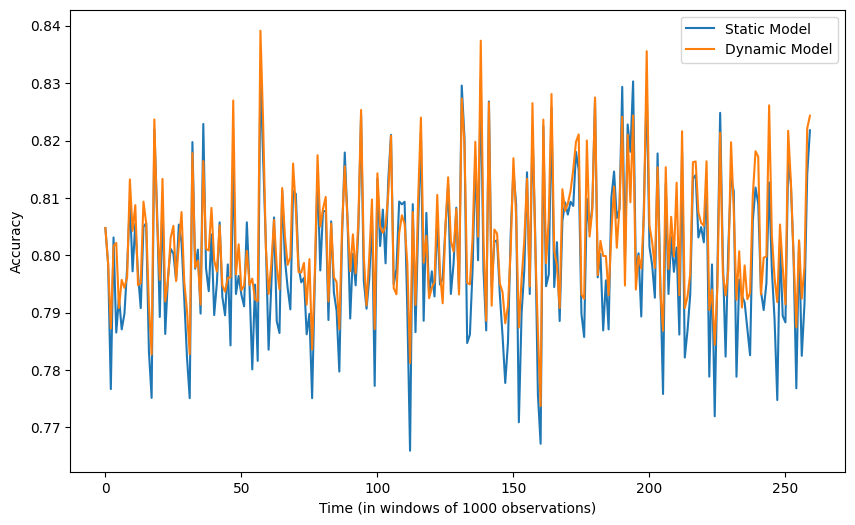

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(static_model_performance, label='Static Model')
plt.plot(dynamic_model_performance, label='Dynamic Model')
plt.xlabel('Time (in windows of 1000 observations)')
plt.ylabel('Accuracy')
plt.legend()
plt.show()